In [1]:
import time
import cv2
import colorFeatureMaps
import orientationFeatureMaps
import graphBasedActivation
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
def calculateFeatureMaps(r, g, b, L, params):
    colorMaps = colorFeatureMaps.compute(r, g, b, L)
    orientationMaps = orientationFeatureMaps.compute(L, params['gaborparams'] , params['thetas'])
    allFeatureMaps = {
        0: colorMaps['CBY'],
        1: colorMaps['CRG'],
        2: colorMaps['L'],
        3: orientationMaps
    }
    return allFeatureMaps

def getPyramids(image, max_level):
    imagePyr = [cv2.pyrDown(image)]
    for i in range(1, max_level):
        # imagePyr.append(cv2.resize(p, (32, 28), interpolation=cv2.INTER_CUBIC))
        imagePyr.append(cv2.pyrDown(imagePyr[i-1]))
    return imagePyr[1:]

def run(image, params):
    b = image[:,:,0]
    g = image[:,:,1]
    r = image[:,:,2]
    L = np.maximum(np.maximum(r, g), b)

    b_pyr = getPyramids(b, params['max_level'])
    g_pyr = getPyramids(g, params['max_level'])
    r_pyr = getPyramids(r, params['max_level'])
    L_pyr = getPyramids(L, params['max_level'])

    featMaps = {
        0: [],
        1: [],
        2: [],
        3: []
    }

    # calculating feature maps

    for i in range(0, len(b_pyr)):
        p_r = r_pyr[i]
        p_g = g_pyr[i]
        p_b = b_pyr[i]
        p_L = L_pyr[i]

        maps = calculateFeatureMaps(p_r, p_g, p_b, p_L, params)
        # we calculate feature maps and then resize
        for i in range(0,3):
            resized_m = cv2.resize(maps[i], (32, 28), interpolation=cv2.INTER_CUBIC)
            featMaps[i].append(resized_m)

        for m in maps[3]:
            resized_m = cv2.resize(m, (32, 28), interpolation=cv2.INTER_CUBIC)
            featMaps[3].append(resized_m)
        # featMaps[0].append(maps[0])
        # featMaps[1].append(maps[1])
        # featMaps[2].append(maps[2])

    # calculating activation maps

    activationMaps = []
    activation_sigma = params['sigma_frac_act']*np.mean([32, 28]) # the shape of map

    for i in range(0,4):
        for map in featMaps[i]:
            activationMaps.append(graphBasedActivation.calculate(map, activation_sigma))


    # normalizing activation maps

    normalisedActivationMaps = []
    normalisation_sigma = params['sigma_frac_norm']*np.mean([32, 28])

    for map in activationMaps:
        normalisedActivationMaps.append(graphBasedActivation.normalize(map, normalisation_sigma))


    # combine normalised maps

    mastermap = normalisedActivationMaps[0]
    for i in range(1, len(normalisedActivationMaps)):
        mastermap = np.add(normalisedActivationMaps[i], mastermap)


    # post process

    gray = cv2.normalize(mastermap, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # blurred = cv2.GaussianBlur(gray,(4,4), 4)
    # gray2 = cv2.normalize(blurred, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    mastermap_res = cv2.resize(gray, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

    return mastermap_res

def setupParams():
    gaborparams = {
        'stddev': 2,
        'elongation': 2,
        'filterSize': -1,
        'filterPeriod': np.pi
    }

    params = {
        'gaborparams': gaborparams,
        'sigma_frac_act': 0.15,
        'sigma_frac_norm': 0.06,
        'max_level': 4,
        'thetas': [0, 45, 90, 135]
    }

    return params

processing./images/calculator.jpg


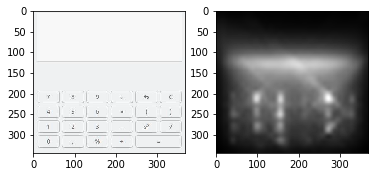

In [3]:
# Base case
params = setupParams()
imname = "./images/calculator.jpg" 
print("processing" + imname)
img = cv2.imread(imname)
img = img / 255.0

saliency_map = run(img, params)*255.0

oname = "./outputs/" + imname+ "_out" +str(time.time())+".jpg"
cv2.imwrite(oname, saliency_map)


fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img, cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(saliency_map, cmap='gray')
plt.show()

In [4]:
def grade(image):
    tmp_arr = np.array(image)[300:331,248:358]
    
    return tmp_arr.sum()

def alter(img, new_color):
    image = img.copy()
    for y in range(300,333):
        for x in range(248, 360):
            color = image[y,x]
            if color[0] > 0.9:
                image[y,x] = new_color


    return image

Base score: 96876.55
Score: 514300.16
Score: 516752.12
Score: 520668.12
Score: 535105.6
Score: 523225.72
Score: 528575.9
Score: 523714.8
Score: 520635.03
Score: 520252.8
Score: 517182.88
Best score: 535105.6


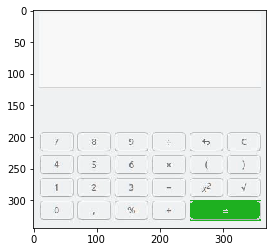

In [5]:
# Optimization A8.1 with GBVS
params = setupParams()
imname = "./images/calculator.jpg" 
img = cv2.imread(imname)
img = img / 255.0

saliency_map = run(img, params)*255.0
best_score = grade(saliency_map)
best_design = img.copy()
print("Base score:", best_score)

for i in range(10):
    altered_img = alter(img, [random.random(),random.random(),random.random()])
    saliency_map = run(altered_img, params)*255.0
    
    score = grade(saliency_map)
    plt.imshow(altered_img)
    print("Score:", score)
    if score > best_score:
        best_design = altered_img.copy()
        best_score = score
print("Best score:", best_score)
plt.imshow(best_design)

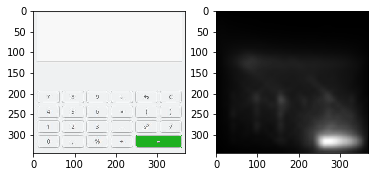

In [6]:
# Show the results
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(best_design)
fig.add_subplot(1,2,2)
plt.imshow(run(best_design, params)*255.0, cmap='gray')
plt.show()

In [7]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam
from vis.visualization import visualize_saliency, overlay
from keras.applications import ResNet50
from vis.utils import utils
from keras import activations
from vis.utils import utils
from matplotlib import pyplot as plt
import warnings

def grade_resnet(image):
    tmp_arr = np.array(saliency_map_resnet)[200:223,160:220]
    return tmp_arr.sum()

def run_resnet(image):
    warnings.filterwarnings('ignore')
    # Build the ResNet50 network with ImageNet weights
    model = ResNet50(weights='imagenet', include_top=True)

    # Utility to search for layer index by name. 
    # Alternatively we can specify this as -1 since it corresponds to the last layer.
    layer_idx = utils.find_layer_idx(model, 'fc1000')

    # Swap softmax with linear
    model.layers[layer_idx].activation = activations.linear
    model = utils.apply_modifications(model)
    
    
    penultimate_layer = utils.find_layer_idx(model, 'res5c_branch2c')
    grads = visualize_cam(model, layer_idx, filter_indices=20, 
                              seed_input=image, penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None)
    return grads

Using TensorFlow backend.


Base score: 131676.88
Score: 141976.66
Score: 137440.94
Score: 129829.15
Score: 131202.67
Score: 130598.625
Score: 134973.73
Score: 132547.31
Score: 137867.84
Score: 132832.78
Score: 137622.31
Best score: 141976.66


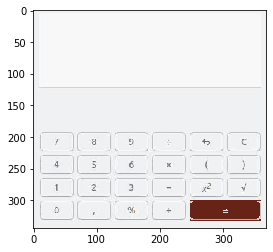

In [8]:
# Optimization A8.2 by combining GBVS and ResNet
import time
params = setupParams()
imname = "./images/calculator.jpg" 
img = cv2.imread(imname)
img = img / 255.0


# GBVS base
saliency_map = run(img, params)*255.0

# Resnet base
saliency_map_resnet = run_resnet(img)*255.0
saliency_map_resnet_org = saliency_map_resnet.copy()



best_score = grade_resnet(saliency_map_resnet) + grade(saliency_map)

best_design = img.copy()
print("Base score:", best_score)

for i in range(10):
    altered_img = alter(img, [random.random(),random.random(),random.random()])
    
    # Resnet saliency
    saliency_map_resnet = run_resnet(altered_img)*255.0
    
    # GBVS saliency
    saliency_map = run(img, params)*255.0
    
    score = grade_resnet(saliency_map_resnet) + grade(saliency_map)

    print("Score:", score)
    if score > best_score:
        best_design = altered_img.copy()
        best_score = score
    time.sleep(10) # Rest a bit, so that my PC doesn't freeze
print("Best score:", best_score)
plt.imshow(best_design)

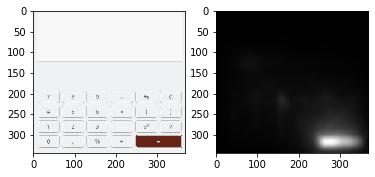

In [9]:
# Show the results
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(best_design)
fig.add_subplot(1,2,2)
plt.imshow(run(best_design, params)*255.0, cmap='gray')
plt.show()

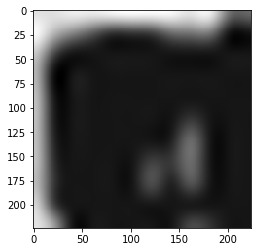

In [10]:
# Best design with combined strategy
plt.imshow(run_resnet(best_design), cmap='gray')

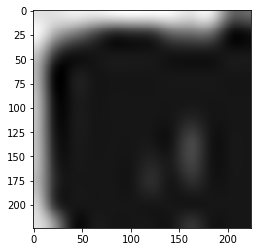

In [11]:
# Original resnet saliency map before optimization
plt.imshow(saliency_map_resnet_org, cmap='gray')